# Biquad Filter Designer

Biqaud filter designer using the formulas from the [Audio EQ Cookbook](https://www.w3.org/TR/audio-eq-cookbook/).

$$ H(z) = \frac{b_0 + b_1z^{-1} + b_2z^{-2}}{a_0 + a_1z^{-1} + a_2z^{-2}} $$

## Filter Configuration

### Imports

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
from abc import ABC, abstractmethod

# Suppress divide-by-zero warnings
import warnings
warnings.filterwarnings('ignore')


### Filter Base Class

In [2]:

class FilterBase(ABC):
    def __init__(self, sampling_freq = 48000):
        self.sampling_freq = sampling_freq
        self.nyquist_freq = self.sampling_freq / 2.

        self.center_freq = self.nyquist_freq
        self.Q = np.sqrt(0.5)
        
        self.b0 = 0.
        self.b1 = 0.
        self.b2 = 0.
        self.a0 = 1.
        self.a1 = 0.
        self.a2 = 0.

    def configure(self, center_freq, Q=np.sqrt(0.5)):
        # Constrain 0 <= center_freq <= self.nyquist_freq
        center_freq = max(0, min(center_freq, self.nyquist_freq))
        self.center_freq = center_freq

        if (Q == None) or (Q <= 0):
            Q = np.sqrt(0.5)
        self.Q = min(Q, 20)

        # Convert frequency in Hz to omega frequency [0, 2*PI]
        self.omega = 2*np.pi * center_freq / self.sampling_freq
        self.sn = np.sin(self.omega)
        self.cs = np.cos(self.omega)
        self.alpha = self.sn / (2 * Q)
        (b0, b1, b2, a0, a1, a2) = self.calculate_coefficients()

        # Normalize a0 to 1
        self.b0 = (b0/a0)
        self.b1 = (b1/a0)
        self.b2 = (b2/a0)
        self.a0 = 1
        self.a1 = (a1/a0)
        self.a2 = (a2/a0)

    @abstractmethod
    def calculate_coefficients(self):
        pass

    def num(self):
        return [self.b0, self.b1, self.b2]

    def den(self):
        return [self.a0, self.a1, self.a2]

    def __str__(self):
        return "num = [{}, {}, {}], den = [{}, {}, {}]".format(self.b0, self.b1, self.b2, self.a0, self.a1, self.a2)



### Designer Summary

In [3]:
def mag2db(mag):
    """
    Convert magnitude values into dB (decibels)
    """
    return 20*np.log10(mag)

def print_coefficients(f):
    print("a0 = ", f.a0)
    print("a1 = ", f.a1)
    print("a2 = ", f.b2)

    print("b0 = ", f.b0)
    print("b1 = ", f.b1)
    print("b2 = ", f.b2)

def plot_frequency_response(f, H):
    num = f.num()
    den = f.den()
    w, h = signal.freqz(num, den, fs=f.sampling_freq, include_nyquist=True)

    # Convert complex numbers into magnitudes
    mag = np.abs(h)
    mag_db = mag2db(mag)

    def freq_formatter(x, pos):
        return '{:1.0f}k'.format(x/1000)

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(w, mag_db)

    # From https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
    loosley_dashed = (0, (5, 10))
    ax.axhline(-3., color='red', linestyle=loosley_dashed, linewidth=0.5)
    ax.axvline(f.center_freq, color='red', linestyle=loosley_dashed, linewidth=0.5)

    ax.set_ylabel("Magnitude [dB]")
    ax.set_ylim(-48, None)
    # ax.set_yticks(np.arange(-48, 30, 12))

    ax.set_xlabel("Frequency [Hz]")
    ax.xaxis.set_major_formatter(freq_formatter)
    ax.set_xticks(np.arange(0, f.nyquist_freq, 2000))

    ax.grid(True)
    ax.set_title("Frequency Response")
    plt.show()

def print_poles_and_zeros(f, H):
    poles = H.poles
    poles_magnitude = np.round(np.abs(poles), 3)
    poles_angle =  np.round(np.degrees(np.angle(poles)), 1)
    poles_freq = np.round(np.angle(poles) / (2*np.pi) * f.sampling_freq)
    poles_summary = [list(a) for a in zip(poles_magnitude, poles_angle, poles_freq)]
    print("Poles: ", poles_summary)

    zeros = H.zeros
    zeros_magnitude = np.round(np.abs(zeros), 3)
    zeros_angle =  np.round(np.degrees(np.angle(zeros)), 1)
    zeros_freq = np.round(np.angle(zeros) / (2*np.pi) * f.sampling_freq)
    zeros_summary = [list(a) for a in zip(zeros_magnitude, zeros_angle, zeros_freq)]
    print("Zeros: ", zeros_summary)

def plot_poles_and_zeros(f, H):
    poles = H.poles
    zeros = H.zeros
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Plot unit circle
    ax.plot(np.linspace(0,2*np.pi,101), np.ones(101), color='blue')

    ax.plot(np.angle(poles), np.abs(poles), marker='x', color='green', linestyle='none');
    ax.plot(np.angle(zeros), np.abs(zeros), marker='o', color='red', linestyle='none', fillstyle='none')

    ax.set_rmax(1.5)
    ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
    #ax.set_rlabel_position(135+22.5)  # Move radial labels away from markers
    ax.grid(True)
    ax.set_title("Poles and Zeros")
    plt.show()

def design_summary(filter):
    num = filter.num()
    den = filter.den()
    H = signal.TransferFunction(num, den, dt=True)
    print_coefficients(filter)
    plot_frequency_response(filter, H)
    print_poles_and_zeros(filter, H)
    plot_poles_and_zeros(filter, H)


### Low Pass Filter

Use class `LowPassFilter`.

In [4]:
class LowPassFilter(FilterBase):
    def calculate_coefficients(self):
        b0 = (1. - self.cs) / 2.
        b1 = 1. - self.cs
        b2 = (1. - self.cs) / 2.
        a0 = 1. + self.alpha
        a1 = -2. * self.cs
        a2 = 1. - self.alpha
        return (b0, b1, b2, a0, a1, a2)


### High Pass Filter

Use class `HighPassFilter`.

In [5]:
class HighPassFilter(FilterBase):
    def calculate_coefficients(self):
        b0 = (1. +self.cs) / 2.
        b1 = -1*(1 + self.cs)
        b2 = (1 + self.cs) / 2.
        a0 = 1 + self.alpha
        a1 = -2 * self.cs
        a2 = 1 - self.alpha
        return (b0, b1, b2, a0, a1, a2)

### Band Pass Filter (Constant Skirt Gain, Peak Gain = Q)

Use class `BandPassConstantSkirtFilter`.

In [6]:
class BandPassConstantSkirtFilter(FilterBase):
    def calculate_coefficients(self):
        b0 = self.sn / 2.
        b1 = 0
        b2 = -1 * (self.sn / 2.)
        a0 = 1 + self.alpha
        a1 = -2 * self.cs
        a2 = 1 - self.alpha
        return (b0, b1, b2, a0, a1, a2)

### Band Pass Filter (Constant 0 dB Peak Gain)

Use class `BandPassConstantPeakFilter`.

In [7]:
class BandPassConstantPeakFilter(FilterBase):
    def calculate_coefficients(self):
        b0 = self.alpha
        b1 = 0
        b2 = -1 * self.alpha
        a0 = 1 + self.alpha
        a1 = -2 * self.cs
        a2 = 1 - self.alpha
        return (b0, b1, b2, a0, a1, a2)

## Filter Designer

a0 =  1
a1 =  -0.9486526681271266
a2 =  0.23716316703178153
b0 =  0.23716316703178153
b1 =  0.47432633406356306
b2 =  0.23716316703178153


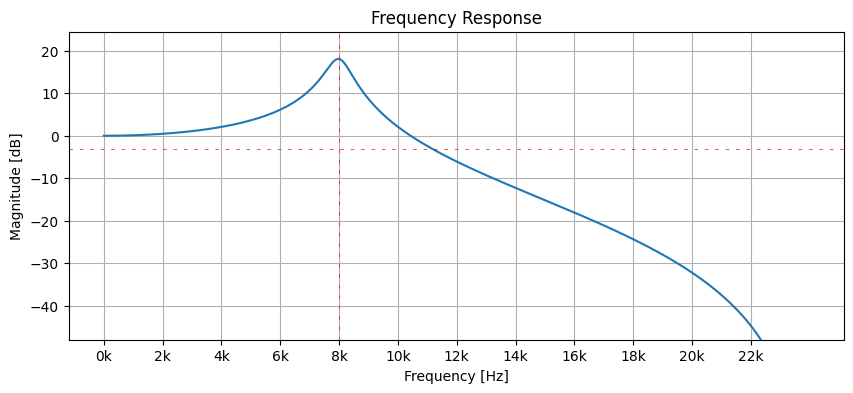

Poles:  [[0.947, 60.0, 7994.0], [0.947, -60.0, -7994.0]]
Zeros:  [[1.0, 180.0, 24000.0], [1.0, 180.0, 24000.0]]


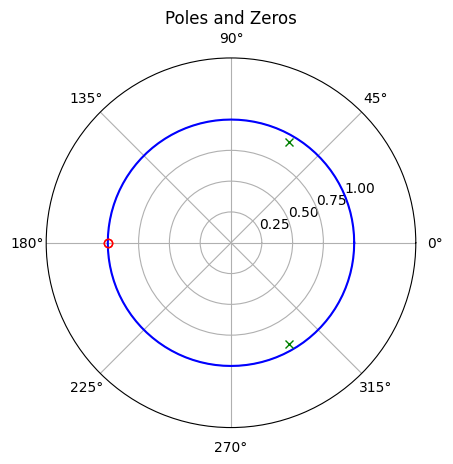

In [8]:
filter = LowPassFilter()
filter.configure(center_freq = 8000, Q = 8)

design_summary(filter)